# Model Evaluation for Appliance Energy Prediction
# Comprehensive performance analysis and visualization


## 1. Imports and Setup

In [12]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import json
import warnings
warnings.filterwarnings('ignore')
from src.config import model_paths

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


## 2. Load Predictions

In [14]:
predictions_df = pd.read_csv(model_paths.test_predictions)
print(f"Predictions loaded: {len(predictions_df):,} samples")

# Load training metadata
with open(model_paths.training_metadata, 'r') as f:
    metadata = json.load(f)


print("\nTraining Metadata:")
print(f"  Training date:    {metadata['training_date']}")
print(f"  Model type:       {metadata['model_type']}")
print(f"  Features:         {metadata['n_features']}")
print(f"  Best iteration:   {metadata['best_iteration']}")
print(f"  Used smoothing:   {metadata['used_smoothing']}")

# Preview predictions
print("\nPredictions preview:")
print(predictions_df.head())

Predictions loaded: 2,960 samples

Training Metadata:
  Training date:    2025-12-29 17:28:48
  Model type:       XGBoost Quantile Regression
  Features:         55
  Best iteration:   595
  Used smoothing:   False

Predictions preview:
                  date  actual  predicted_raw  predicted_smoothed  \
0  2016-05-07 04:30:00    60.0      59.050926           59.050926   
1  2016-05-07 04:40:00    60.0      56.689144           56.689144   
2  2016-05-07 04:50:00    50.0      57.092370           57.092370   
3  2016-05-07 05:00:00    50.0      58.168976           58.168976   
4  2016-05-07 05:10:00    50.0      53.459080           53.459080   

   final_prediction  
0         59.050926  
1         56.689144  
2         57.092370  
3         58.168976  
4         53.459080  


## 3. Extract Predictions and Actuals

In [15]:
y_true = predictions_df['actual'].values
y_pred_raw = predictions_df['predicted_raw'].values
y_pred_smoothed = predictions_df['predicted_smoothed'].values
y_pred_final = predictions_df['final_prediction'].values
dates = pd.to_datetime(predictions_df['date'])

print(f"Data shapes:")
print(f"  Actual:           {y_true.shape}")
print(f"  Predicted (raw):  {y_pred_raw.shape}")
print(f"  Predicted (final): {y_pred_final.shape}")

Data shapes:
  Actual:           (2960,)
  Predicted (raw):  (2960,)
  Predicted (final): (2960,)


## 4. Calculate Core Metrics

In [16]:
def calculate_metrics(y_true, y_pred, name="Model"):
    """Calculate all evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'name': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# %%
# Calculate metrics for all prediction types
metrics_raw = calculate_metrics(y_true, y_pred_raw, "Raw Predictions")
metrics_smoothed = calculate_metrics(y_true, y_pred_smoothed, "Smoothed Predictions")
metrics_final = calculate_metrics(y_true, y_pred_final, "Final Predictions")

# Create metrics comparison table
metrics_df = pd.DataFrame([metrics_raw, metrics_smoothed, metrics_final])

print("\n" + "="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)
print(f"\n{metrics_df.to_string(index=False)}")
print("\n" + "="*80)



PERFORMANCE METRICS COMPARISON

                name       MAE      RMSE       R2      MAPE
     Raw Predictions 26.863695 72.233002 0.368351 18.539918
Smoothed Predictions 27.004447 72.634313 0.361313 18.537267
   Final Predictions 26.863695 72.233002 0.368351 18.539918



## 5. Error Distribution Analysis
##### Analyze prediction errors across different ranges


In [17]:
# Calculate errors
errors = np.abs(y_true - y_pred_final)

print("\n" + "="*80)
print("ERROR DISTRIBUTION")
print("="*80)

# Define error ranges
ranges = [5, 10, 20, 30, 50, 100, 200]
print(f"\n{'Error Range':<15} {'Count':<10} {'Percentage':<12} {'Cumulative'}")
print("-" * 60)

cumsum = 0
for i, threshold in enumerate(ranges):
    if i == 0:
        count = (errors <= threshold).sum()
        label = f"0-{threshold}"
    else:
        count = ((errors > ranges[i-1]) & (errors <= threshold)).sum()
        label = f"{ranges[i-1]}-{threshold}"
    
    pct = count / len(errors) * 100
    cumsum += pct
    print(f"{label:<15} {count:<10} {pct:>10.2f}%    {cumsum:>10.2f}%")

# Large errors
count = (errors > ranges[-1]).sum()
pct = count / len(errors) * 100
cumsum += pct
print(f"{f'>{ranges[-1]}':<15} {count:<10} {pct:>10.2f}%    {cumsum:>10.2f}%")



ERROR DISTRIBUTION

Error Range     Count      Percentage   Cumulative
------------------------------------------------------------
0-5             1000            33.78%         33.78%
5-10            721             24.36%         58.14%
10-20           581             19.63%         77.77%
20-30           206              6.96%         84.73%
30-50           162              5.47%         90.20%
50-100          112              3.78%         93.99%
100-200         80               2.70%         96.69%
>200            98               3.31%        100.00%


## 6. Accuracy by Tolerance
###### Percentage of predictions within acceptable error margins

In [18]:
print("\n" + "="*80)
print("ACCURACY BY TOLERANCE")
print("="*80)
print(f"\n{'Tolerance':<15} {'Within Count':<15} {'Percentage'}")
print("-" * 50)

tolerances = [5, 10, 15, 20, 30, 50, 100, 150, 200]
accuracy_results = []

for tol in tolerances:
    within = (errors <= tol).sum()
    pct = within / len(errors) * 100
    accuracy_results.append({'tolerance': tol, 'count': within, 'percentage': pct})
    print(f"±{tol:<14} {within:<15} {pct:>10.1f}%")

accuracy_df = pd.DataFrame(accuracy_results)



ACCURACY BY TOLERANCE

Tolerance       Within Count    Percentage
--------------------------------------------------
±5              1000                  33.8%
±10             1721                  58.1%
±15             2087                  70.5%
±20             2302                  77.8%
±30             2508                  84.7%
±50             2670                  90.2%
±100            2782                  94.0%
±150            2835                  95.8%
±200            2862                  96.7%


## 7. Error Statistics Summary


In [19]:
print("\n" + "="*80)
print("ERROR STATISTICS")
print("="*80)
print(f"\nMean Error:       {errors.mean():.2f} Wh")
print(f"Median Error:     {np.median(errors):.2f} Wh")
print(f"Std Dev:          {errors.std():.2f} Wh")
print(f"Min Error:        {errors.min():.2f} Wh")
print(f"Max Error:        {errors.max():.2f} Wh")
print(f"25th Percentile:  {np.percentile(errors, 25):.2f} Wh")
print(f"75th Percentile:  {np.percentile(errors, 75):.2f} Wh")
print(f"95th Percentile:  {np.percentile(errors, 95):.2f} Wh")
print(f"99th Percentile:  {np.percentile(errors, 99):.2f} Wh")



ERROR STATISTICS

Mean Error:       26.86 Wh
Median Error:     8.12 Wh
Std Dev:          67.05 Wh
Min Error:        0.00 Wh
Max Error:        728.19 Wh
25th Percentile:  3.43 Wh
75th Percentile:  18.02 Wh
95th Percentile:  122.17 Wh
99th Percentile:  362.71 Wh


## 8. Performance by Usage Level

In [20]:
def analyze_by_usage_level(y_true, y_pred):
    """Analyze performance across usage levels"""
    errors = np.abs(y_true - y_pred)
    
    # Define usage levels
    levels = [
        (0, 100, "Low (0-100)"),
        (100, 200, "Medium (100-200)"),
        (200, 300, "High (200-300)"),
        (300, np.inf, "Very High (>300)")
    ]
    
    results = []
    for min_val, max_val, label in levels:
        mask = (y_true >= min_val) & (y_true < max_val)
        if mask.sum() > 0:
            level_errors = errors[mask]
            results.append({
                'Level': label,
                'Count': mask.sum(),
                'MAE': level_errors.mean(),
                'Median Error': np.median(level_errors),
                'Max Error': level_errors.max()
            })
    
    return pd.DataFrame(results)

# %%
usage_analysis = analyze_by_usage_level(y_true, y_pred_final)

print("\n" + "="*80)
print("PERFORMANCE BY USAGE LEVEL")
print("="*80)
print(f"\n{usage_analysis.to_string(index=False)}")



PERFORMANCE BY USAGE LEVEL

           Level  Count        MAE  Median Error  Max Error
     Low (0-100)   2155   9.014185      6.189056 141.628650
Medium (100-200)    549  25.020790     16.748000 188.210050
  High (200-300)    121  76.240073     67.600340 215.971580
Very High (>300)    135 275.033372    272.142390 728.185776


## 9. Performance by Time of Day
###### Analyze prediction accuracy across different hours


In [21]:
import numpy as np
import pandas as pd

def analyze_by_hour(predictions_df):
    """Analyze performance by hour of day including mode"""
    
    df = predictions_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['error'] = np.abs(df['actual'] - df['final_prediction'])
    
    hourly_stats = (
        df.groupby('hour')['error']
        .agg(
            Mean_Error='mean',
            Median_Error='median',
            Mode_Error=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
            Count='count'
        )
        .reset_index()
        .rename(columns={'hour': 'Hour'})
    )
    
    return hourly_stats

hourly_analysis = analyze_by_hour(predictions_df)

print("\n" + "="*80)
print("PERFORMANCE BY HOUR OF DAY")
print("="*80)
print(hourly_analysis.to_string(index=False))



PERFORMANCE BY HOUR OF DAY
 Hour  Mean_Error  Median_Error  Mode_Error  Count
    0    5.056047      4.553453    0.003914    120
    1    5.302130      4.680085    0.002953    120
    2    6.026101      5.351959    0.006870    120
    3    5.363624      5.087700    0.011684    120
    4    7.225159      4.494644    0.004520    123
    5   12.419556      5.263687    0.012012    126
    6   13.482402      7.504091    0.042255    126
    7   47.221277     10.299192    0.034910    126
    8   36.740819     12.615975    0.075620    126
    9   52.387232     11.231524    0.058266    126
   10   39.051403     11.497857    0.000990    126
   11   45.022748     10.234322    0.155727    126
   12   30.768793     10.627640    0.346756    126
   13   30.539528     10.781607    0.217190    126
   14   26.283979      9.334287    0.059216    126
   15   21.373253      7.974165    0.069120    126
   16   48.954222     12.045035    0.060460    126
   17   94.455732     31.972640    0.131035    125
   

## 10. Visualization 1: Actual vs Predicted Time Series

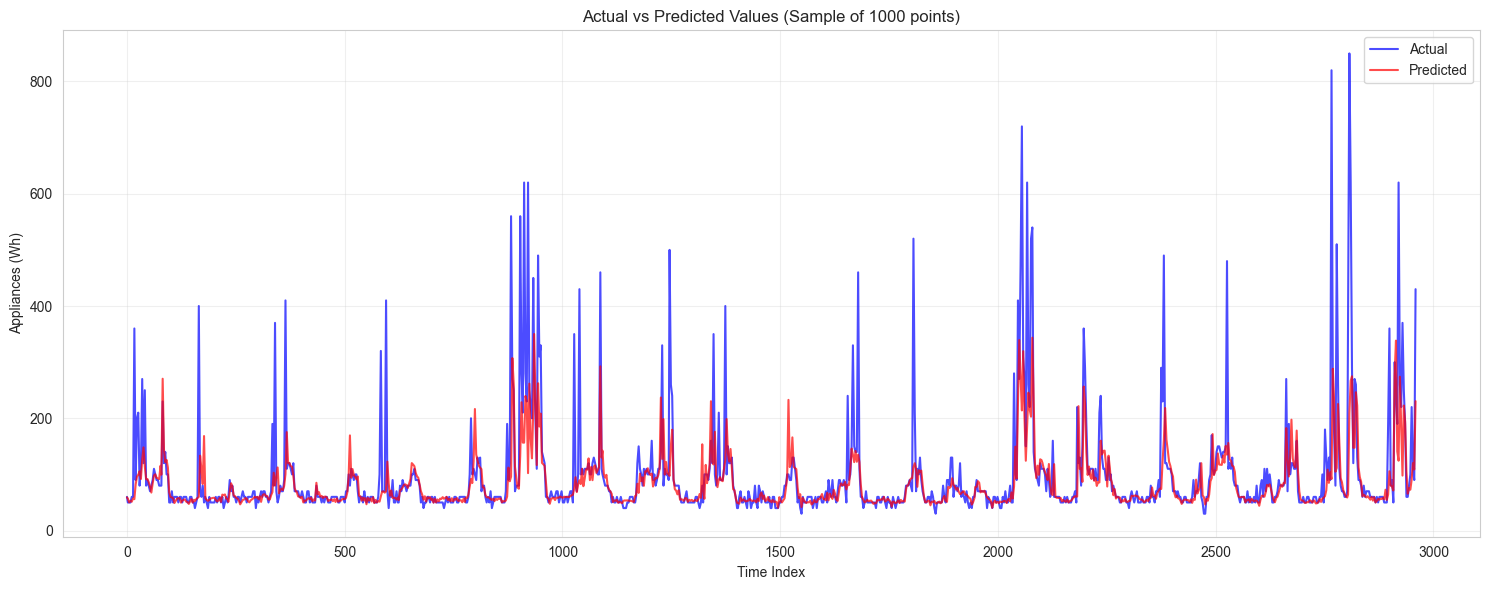

✓ Time series plot saved


In [22]:
n_plot = min(1000, len(y_true))
indices = np.linspace(0, len(y_true)-1, n_plot, dtype=int)

plt.figure(figsize=(15, 6))
plt.plot(indices, y_true[indices], label='Actual', alpha=0.7, linewidth=1.5, color='blue')
plt.plot(indices, y_pred_final[indices], label='Predicted', alpha=0.7, linewidth=1.5, color='red')
plt.xlabel('Time Index')
plt.ylabel('Appliances (Wh)')
plt.title(f'Actual vs Predicted Values (Sample of {n_plot} points)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
model_paths.evaluation_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(model_paths.timeseries_plot, dpi=150, bbox_inches='tight')

plt.show()

print("✓ Time series plot saved")


## 11. Visualization 2: Scatter Plot
###### Correlation between actual and predicted values

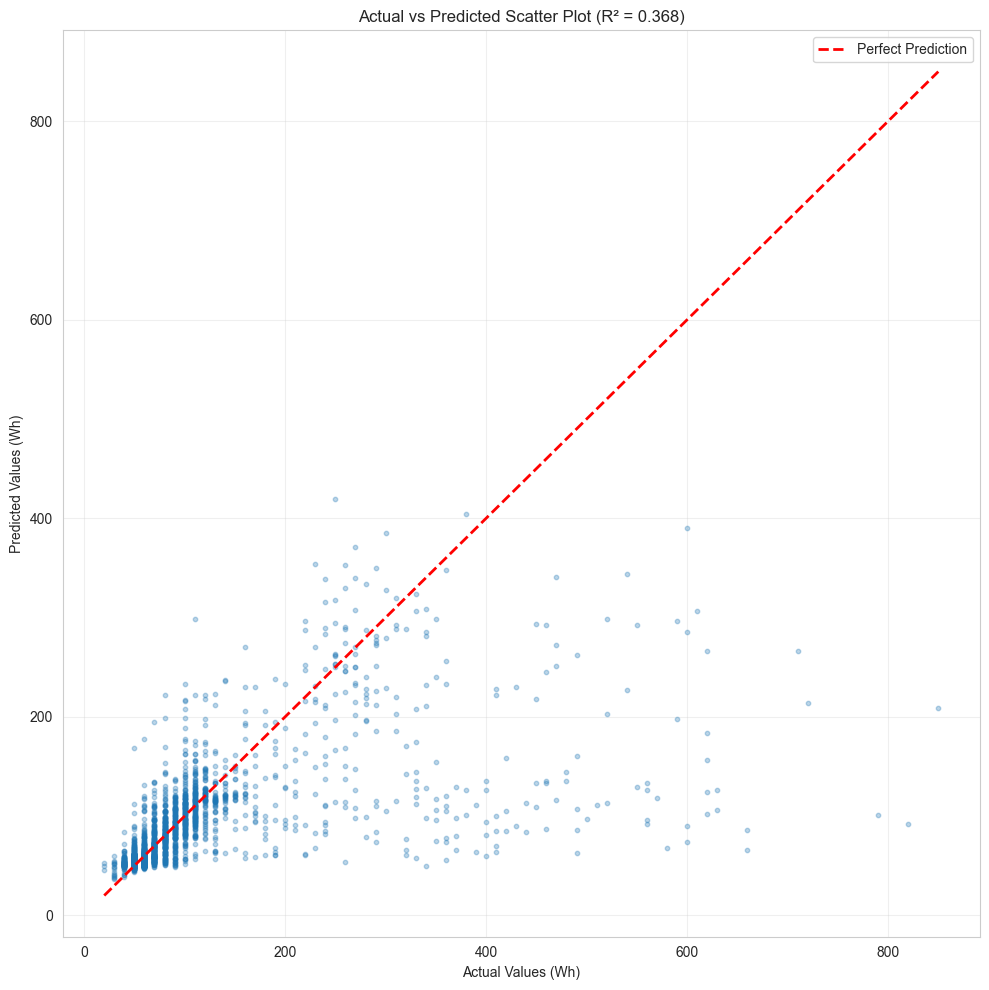

✓ Scatter plot saved


In [23]:
plt.figure(figsize=(10, 10))

# Sample for clarity if dataset is large
if len(y_true) > 5000:
    sample_idx = np.random.choice(len(y_true), 5000, replace=False)
    y_true_plot = y_true[sample_idx]
    y_pred_plot = y_pred_final[sample_idx]
else:
    y_true_plot = y_true
    y_pred_plot = y_pred_final

plt.scatter(y_true_plot, y_pred_plot, alpha=0.3, s=10)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Wh)')
plt.ylabel('Predicted Values (Wh)')
plt.title(f'Actual vs Predicted Scatter Plot (R² = {metrics_final["R2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(model_paths.scatter_plot, dpi=150, bbox_inches='tight')
plt.show()

print("✓ Scatter plot saved")


## 12. Generate Evaluation Report

In [24]:
report = {
    'model_info': {
        'model_type': metadata['model_type'],
        'training_date': metadata['training_date'],
        'n_features': metadata['n_features'],
        'best_iteration': metadata['best_iteration']
    },
    'dataset_info': {
        'n_train': metadata['n_train_samples'],
        'n_val': metadata['n_val_samples'],
        'n_test': metadata['n_test_samples']
    },
    'performance_metrics': {
        'mae': float(metrics_final['MAE']),
        'rmse': float(metrics_final['RMSE']),
        'r2': float(metrics_final['R2']),
        'mape': float(metrics_final['MAPE'])
    },
    'error_statistics': {
        'mean_error': float(errors.mean()),
        'median_error': float(np.median(errors)),
        'std_error': float(errors.std()),
        'max_error': float(errors.max()),
        'p95_error': float(np.percentile(errors, 95))
    },
    'accuracy_by_tolerance': {
        f'within_{int(row.tolerance)}': float(row.percentage)
        for row in accuracy_df.itertuples()
    },
    'performance_by_usage': usage_analysis.to_dict('records'),
    'smoothing_impact': {
        'raw_mae': float(metrics_raw['MAE']),
        'smoothed_mae': float(metrics_smoothed['MAE']),
        'improvement': float(metrics_raw['MAE'] - metrics_smoothed['MAE'])
    }
}

# Save report
with open(model_paths.evaluation_report, 'w') as f:
    json.dump(report, f, indent=2)


print(f"✓ Evaluation report saved ")


✓ Evaluation report saved 


## 13. Final Summary


In [25]:
print("\n" + "="*80)
print("EVALUATION COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n{'METRIC':<20} {'VALUE'}")
print("-" * 50)
print(f"{'MAE':<20} {metrics_final['MAE']:.2f} Wh")
print(f"{'RMSE':<20} {metrics_final['RMSE']:.2f} Wh")
print(f"{'R² Score':<20} {metrics_final['R2']:.4f}")
print(f"{'MAPE':<20} {metrics_final['MAPE']:.2f}%")

print(f"\n{'ACCURACY':<20} {'VALUE'}")
print("-" * 50)
print(f"{'Within ±10 Wh':<20} {accuracy_df[accuracy_df['tolerance']==10]['percentage'].values[0]:.1f}%")
print(f"{'Within ±20 Wh':<20} {accuracy_df[accuracy_df['tolerance']==20]['percentage'].values[0]:.1f}%")
print(f"{'Within ±50 Wh':<20} {accuracy_df[accuracy_df['tolerance']==50]['percentage'].values[0]:.1f}%")

print(f"\n{'ERROR STATS':<20} {'VALUE'}")
print("-" * 50)
print(f"{'Mean Error':<20} {errors.mean():.2f} Wh")
print(f"{'Median Error':<20} {np.median(errors):.2f} Wh")
print(f"{'95th Percentile':<20} {np.percentile(errors, 95):.2f} Wh")



print("\n" + "="*80)
print("✓ All evaluation complete! Check models/evaluation/ for outputs")
print("="*80)


EVALUATION COMPLETE - FINAL SUMMARY

METRIC               VALUE
--------------------------------------------------
MAE                  26.86 Wh
RMSE                 72.23 Wh
R² Score             0.3684
MAPE                 18.54%

ACCURACY             VALUE
--------------------------------------------------
Within ±10 Wh        58.1%
Within ±20 Wh        77.8%
Within ±50 Wh        90.2%

ERROR STATS          VALUE
--------------------------------------------------
Mean Error           26.86 Wh
Median Error         8.12 Wh
95th Percentile      122.17 Wh

✓ All evaluation complete! Check models/evaluation/ for outputs
